In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2a. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 2b. Optimal weights according to Proposition 2 (for p = 1)
def optimal_weights_prop2(T, eps_over_rho):
    """
    Proposition 2 optimal weights for p = 1:
    - T = history length
    - eps_over_rho = ε/ρ in the paper, where eps in our code is ambuiguity radius, rho is the wasserstein distance between Pt and Pt+1
    Return weights w of length T
    """

    # s = floor(eps / rho)
    s = int(np.floor(eps_over_rho))
    s = max(1, min(s, T))  # truncate to [1, T]
    
    w = np.zeros(T)
    denom = s * (2 * eps_over_rho - s - 1)
    
    for t in range(T - s, T):
        # t runs from T-s to T-1  (0-index)
        w[t] = 2 * ((eps_over_rho) + (t+1) - T - 1) / denom

    return w

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=1.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  'inf') <= lam,
            cp.norm(vec_minus, 'inf') <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=1.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
df = pd.read_csv("historic_demand_2009_2024_noNaN.csv")
df

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009/1/1 0:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009/1/1 0:30,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009/1/1 1:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009/1/1 1:30,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009/1/1 2:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278507,2024/12/5 21:30,44,21:30:00,29114,31431,27212,5377,6622,0,17194,0,736,558,758,1003,-450,-531,999,0
278508,2024/12/5 22:00,45,22:00:00,27204,29846,25477,5486,6622,0,17194,0,868,-193,263,1002,-450,-531,949,0
278509,2024/12/5 22:30,46,22:30:00,26006,28805,24428,5594,6622,0,17194,0,944,-274,211,997,-450,-531,943,0
278510,2024/12/5 23:00,47,23:00:00,23908,26825,22590,5575,6622,0,17194,0,864,-404,-77,280,-450,-522,338,0


In [4]:
df['datetime'] = pd.to_datetime(df['settlement_date'] + ' ' + df['period_hour'])
df = df.set_index('datetime')
df = df.sort_index()

df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df.set_index('settlement_date', inplace=True)

C:\Users\11864\AppData\Local\Temp\ipykernel_34256\2127761336.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['settlement_date'] + ' ' + df['period_hour'])


In [5]:
df = df[df.index <= '2024-11-30']
# Aggregate demand to monthly total
df_monthly = df['nd'].resample('M').sum()
df_monthly

C:\Users\11864\AppData\Local\Temp\ipykernel_34256\1737477922.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['nd'].resample('M').sum()


settlement_date
2009-01-31    63238939
2009-02-28    56073378
2009-03-31    56519297
2009-04-30    49311414
2009-05-31    48437067
                ...   
2024-07-31    33960607
2024-08-31    32288427
2024-09-30    35002964
2024-10-31    39733798
2024-11-30    42742427
Freq: ME, Name: nd, Length: 191, dtype: int64

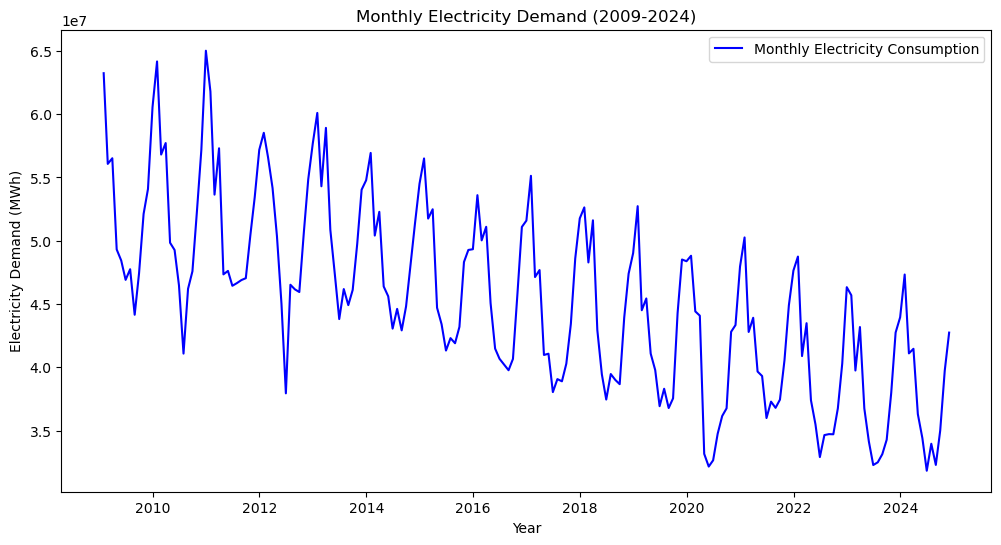

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df_monthly, label="Monthly Electricity Consumption", color="blue")
plt.xlabel("Year")
plt.ylabel("Electricity Demand (MWh)")
plt.title("Monthly Electricity Demand (2009-2024)")
plt.legend()
plt.show()

In [7]:
values = df_monthly.values.astype(float)
dates = df_monthly.index

step_mask = (
    (dates.month == 1) & 
    (dates.year >= 2010) & 
    ((dates.year - 2010) % 5 == 0)
)

step_indices = np.where(step_mask)[0]

print("step dates:", dates[step_indices])

np.random.seed(42)
values_drift = values.copy()

for idx in step_indices:
    current_val = values_drift[idx]
    perc = np.random.uniform(-0.2, 0.2)
    delta = current_val * perc
    values_drift[idx:] += delta

df_drift = pd.Series(values_drift, index=dates, name='nd')
df_drift

step dates: DatetimeIndex(['2010-01-31', '2015-01-31', '2020-01-31'], dtype='datetime64[ns]', name='settlement_date', freq=None)


settlement_date
2009-01-31    6.323894e+07
2009-02-28    5.607338e+07
2009-03-31    5.651930e+07
2009-04-30    4.931141e+07
2009-05-31    4.843707e+07
                  ...     
2024-07-31    4.546899e+07
2024-08-31    4.379681e+07
2024-09-30    4.651135e+07
2024-10-31    5.124218e+07
2024-11-30    5.425081e+07
Freq: ME, Name: nd, Length: 191, dtype: float64

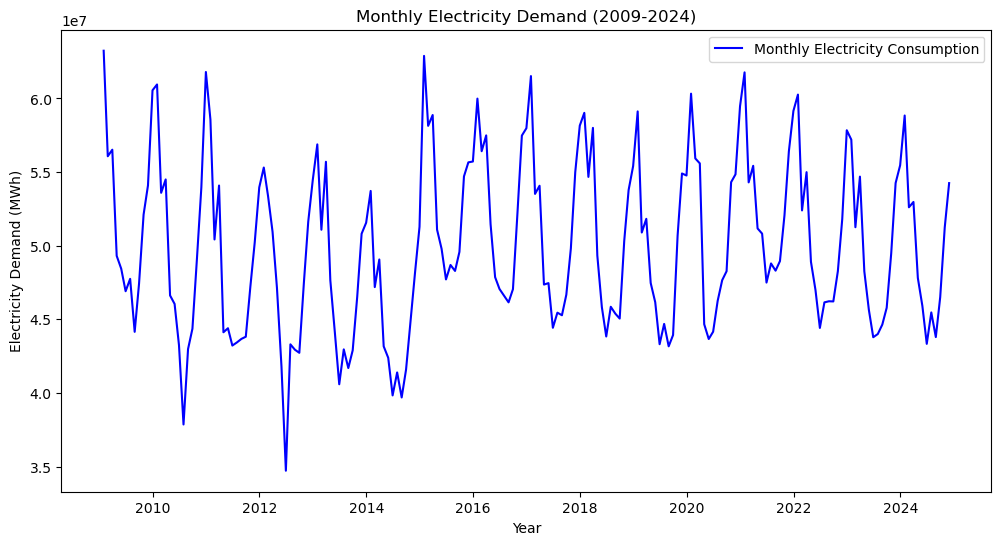

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df_drift, label="Monthly Electricity Consumption", color="blue")
plt.xlabel("Year")
plt.ylabel("Electricity Demand (MWh)")
plt.title("Monthly Electricity Demand (2009-2024)")
plt.legend()
plt.show()

In [9]:
data = df_drift.copy()
data = data.to_frame()
data['settlement_date'] = data.index

data.reset_index(drop=True, inplace=True)

def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 36
X_all, y_all = create_sequences(data['nd'].values, seq_length=seq_length)

T_total = len(y_all)

def rolling_forecast(X_test, y_test, w, first_idx=0):
    history = X_test[first_idx].copy()
    preds = []
    for t in range(len(y_test) - first_idx):
        y_hat = history @ w
        preds.append(y_hat)
        history = np.concatenate([history[1:], [y_hat]])
    return np.array(preds)


=== Time ratio 0.6 ===
Train+Val samples: 93
Test samples     : 62
  Train samples: 74
  Val   samples: 19
  [SAA]   val eps-loss: 1179176.9559519112
  [W-SAA] best val eps-loss: 1236436.473768553 | best decay = 0.95
  [WDRO]  best val eps-loss: 1494631.1592817425 | best decay = 0.75 | best rho = 0.016681005372000592
  [Prop2] best val eps-loss: 531853.3289892639 | best rho = 0.7742636826811278 | best eps/rho = 1.1
>> [SAA]   test eps-loss: 1424070.2019959171
>> [W-SAA] test eps-loss: 1905522.9408998648
>> [WDRO]  test eps-loss: 3998639.3217136795
>> [Prop2] test eps-loss: 3999545.5557626993


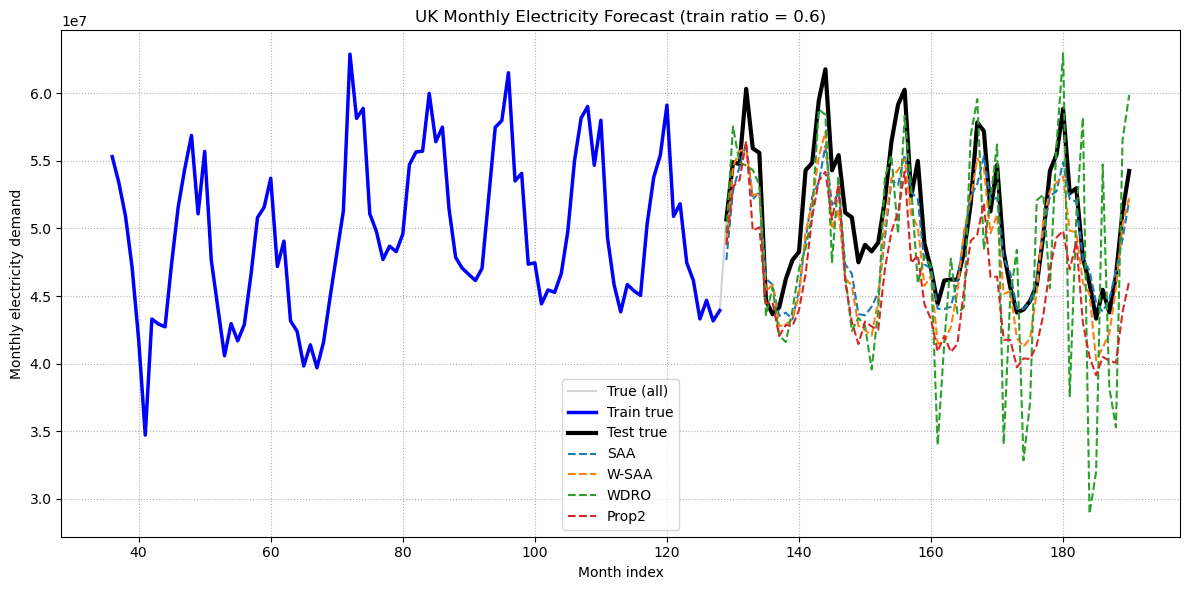


=== Time ratio 0.7 ===
Train+Val samples: 108
Test samples     : 47
  Train samples: 86
  Val   samples: 22
  [SAA]   val eps-loss: 916915.7308058935
  [W-SAA] best val eps-loss: 1136816.3971668808 | best decay = 0.95
  [WDRO]  best val eps-loss: 1305732.5124676498 | best decay = 0.85 | best rho = 0.001291549665014884
  [Prop2] best val eps-loss: 1396563.1822137074 | best rho = 0.00035938136638046257 | best eps/rho = 86.0
>> [SAA]   test eps-loss: 1724624.5754257983
>> [W-SAA] test eps-loss: 2543452.374287329
>> [WDRO]  test eps-loss: 23295805.912835315
>> [Prop2] test eps-loss: 1625296.3001913482


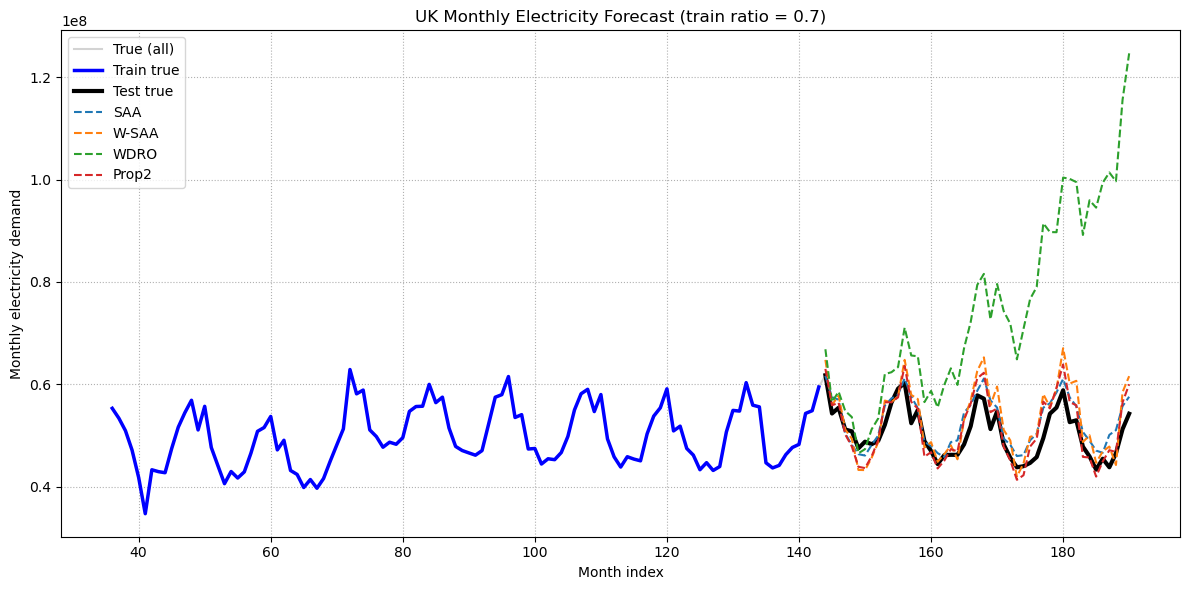


=== Time ratio 0.8 ===
Train+Val samples: 124
Test samples     : 31
  Train samples: 99
  Val   samples: 25
  [SAA]   val eps-loss: 1168244.5054904744
  [W-SAA] best val eps-loss: 954395.5807270193 | best decay = 0.95
  [WDRO]  best val eps-loss: 1068758.5829756507 | best decay = 0.65 | best rho = 0.001291549665014884
  [Prop2] best val eps-loss: 870795.8042416576 | best rho = 0.21544346900318845 | best eps/rho = 1.1
>> [SAA]   test eps-loss: 1008484.1552434518
>> [W-SAA] test eps-loss: 727689.6294454325
>> [WDRO]  test eps-loss: 7210211.406644706
>> [Prop2] test eps-loss: 2727396.3543364224


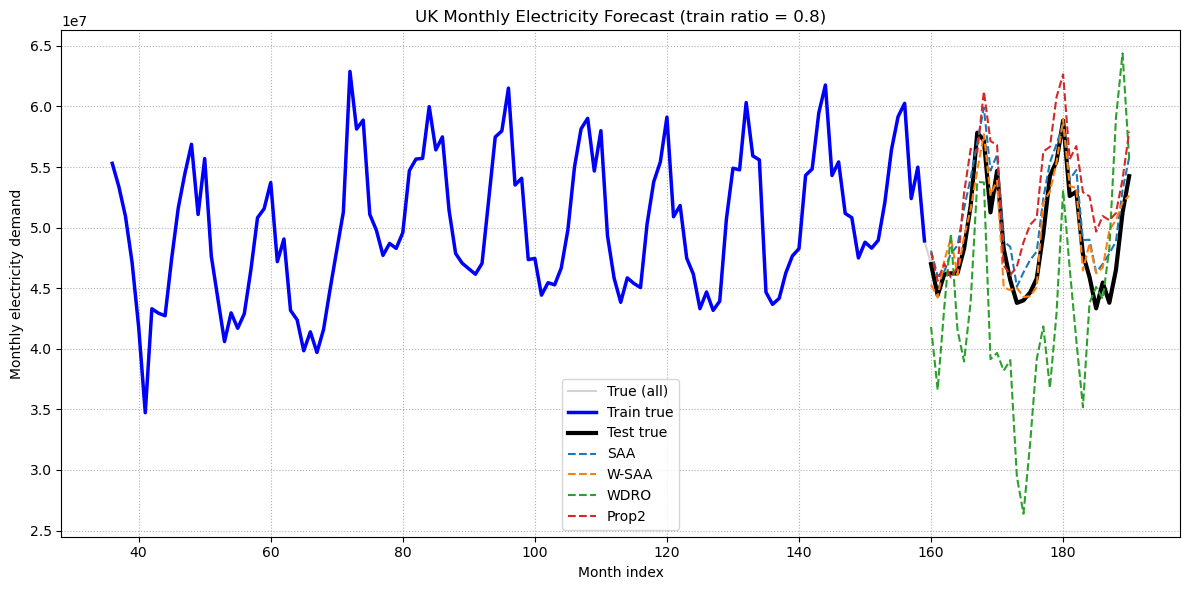

In [10]:
# ================================
# 0. Hyperparameter grid
# ================================
epsilon = 1e6
time_ratios = [0.6, 0.7, 0.8]             # Outer split: train+val vs test
rho_list = np.logspace(-4, 1, num=10)
decay_list = [0.65, 0.75, 0.85, 0.95]

inner_ratio = 0.8               # Inner split: train vs val inside trainval

for ratio in time_ratios:
    # -------- Outer split: Train+Val / Test --------
    T_cut = int(ratio * T_total)

    X_trainval = X_all[:T_cut]
    y_trainval = y_all[:T_cut]

    X_test = X_all[T_cut:]
    y_test = y_all[T_cut:]

    print(f"\n=== Time ratio {ratio:.1f} ===")
    print("Train+Val samples:", X_trainval.shape[0])
    print("Test samples     :", X_test.shape[0])

    # -------- Inner split: Train / Validation (for grid search) --------
    T_inner = int(inner_ratio * T_cut)

    X_train = X_trainval[:T_inner]
    y_train = y_trainval[:T_inner]

    X_val = X_trainval[T_inner:]
    y_val = y_trainval[T_inner:]

    print("  Train samples:", X_train.shape[0])
    print("  Val   samples:", X_val.shape[0])

    T_time_train = len(y_train)   # Used for time-weight construction
    eps_over_rho_list = np.linspace(1.1, T_time_train, 6)

    # ================================
    # 1. Build Box uncertainty set on TRAIN only (for grid search)
    # ================================
    Z_train = np.hstack([X_train, y_train[:, None]])
    ell, upp = build_box_uncertainty(Z_train, qmin=0.01, qmax=0.99, eta=0.02)
    C1, c2, d = build_box_conic_from_bounds(ell, upp, X_train.shape[1])

    # ================================
    # 2. Baseline SAA (no hyperparameters)
    #    Only evaluated on validation
    # ================================
    w_saa_train, _ = solve_empirical_svr_noreg(
        X_train, y_train,
        epsilon=epsilon,
        sample_weights=None
    )

    y_val_pred_saa = X_val @ w_saa_train
    val_loss_saa = eps_ins_loss(y_val, y_val_pred_saa, epsilon).mean()
    print("  [SAA]   val eps-loss:", val_loss_saa)

    # ================================
    # 3. W-SAA: Tune decay using validation set
    # ================================
    best_wsaa_val_loss = np.inf
    best_decay_wsaa = None
    best_w_wsaa_train = None

    for decay in decay_list:
        time_idx = np.arange(T_time_train)

        pi_time_wsaa = time_weights_from_indices(
            time_idx,
            now_t=T_time_train - 1,
            decay=decay
        )
        pi_wsaa_samples = pi_time_wsaa / pi_time_wsaa.sum()

        w_wsaa, _ = solve_empirical_svr_noreg(
            X_train, y_train,
            epsilon=epsilon,
            sample_weights=pi_wsaa_samples
        )

        y_val_pred = X_val @ w_wsaa
        val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

        if val_loss < best_wsaa_val_loss:
            best_wsaa_val_loss = val_loss
            best_decay_wsaa = decay
            best_w_wsaa_train = w_wsaa

    print("  [W-SAA] best val eps-loss:", best_wsaa_val_loss,
          "| best decay =", best_decay_wsaa)

    # ================================
    # 4. WDRO: Tune decay and rho using validation set
    # ================================
    best_wdro_val_loss = np.inf
    best_decay_wdro = None
    best_rho_wdro = None
    best_w_wdro_train = None

    for decay in decay_list:
        time_idx = np.arange(T_time_train)

        pi_time_wdro = time_weights_from_indices(
            time_idx,
            now_t=T_time_train - 1,
            decay=decay
        )
        pi_wdro_samples = pi_time_wdro / pi_time_wdro.sum()

        for rho in rho_list:
            w_wdro, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_wdro_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_val_pred = X_val @ w_wdro
            val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

            if val_loss < best_wdro_val_loss:
                best_wdro_val_loss = val_loss
                best_decay_wdro = decay
                best_rho_wdro = rho
                best_w_wdro_train = w_wdro

    print("  [WDRO]  best val eps-loss:", best_wdro_val_loss,
          "| best decay =", best_decay_wdro,
          "| best rho =", best_rho_wdro)

    # ================================
    # 5. Prop2-DRO: Tune rho and eps_over_rho using validation set
    # ================================
    best_prop2_val_loss = np.inf
    best_rho_prop2 = None
    best_eps_over_rho_prop2 = None
    best_w_prop2_train = None

    for rho in rho_list:
        for eps_over_rho in eps_over_rho_list:
            pi_time_prop2 = optimal_weights_prop2(T_time_train, eps_over_rho)
            pi_prop2_samples = pi_time_prop2 / pi_time_prop2.sum()

            w_prop2, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_prop2_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_val_pred = X_val @ w_prop2
            val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

            if val_loss < best_prop2_val_loss:
                best_prop2_val_loss = val_loss
                best_rho_prop2 = rho
                best_eps_over_rho_prop2 = eps_over_rho
                best_w_prop2_train = w_prop2

    print("  [Prop2] best val eps-loss:", best_prop2_val_loss,
          "| best rho =", best_rho_prop2,
          "| best eps/rho =", best_eps_over_rho_prop2)

    # =========================================================
    # 6. Final retraining on Train+Val and evaluation on Test
    # =========================================================

    # Rebuild Box uncertainty set on Train+Val
    Z_trainval = np.hstack([X_trainval, y_trainval[:, None]])
    ell_tv, upp_tv = build_box_uncertainty(Z_trainval, qmin=0.01, qmax=0.99, eta=0.1)
    C1_tv, c2_tv, d_tv = build_box_conic_from_bounds(ell_tv, upp_tv, X_trainval.shape[1])

    T_time_trainval = len(y_trainval)

    # ---- Final SAA model ----
    w_saa_full, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval,
        epsilon=epsilon,
        sample_weights=None
    )
    y_pred_saa_test = rolling_forecast(X_test, y_test, w_saa_full, 0)
    test_loss_saa = eps_ins_loss(y_test, y_pred_saa_test, epsilon).mean()
    print(">> [SAA]   test eps-loss:", test_loss_saa)

    # ---- Final W-SAA model ----
    time_idx_full = np.arange(T_time_trainval)

    pi_time_wsaa_full = time_weights_from_indices(
        time_idx_full,
        now_t=T_time_trainval - 1,
        decay=best_decay_wsaa
    )
    pi_wsaa_full = pi_time_wsaa_full / pi_time_wsaa_full.sum()

    w_wsaa_full, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval,
        epsilon=epsilon,
        sample_weights=pi_wsaa_full
    )
    y_pred_wsaa_test = rolling_forecast(X_test, y_test, w_wsaa_full, 0)
    test_loss_wsaa = eps_ins_loss(y_test, y_pred_wsaa_test, epsilon).mean()
    print(">> [W-SAA] test eps-loss:", test_loss_wsaa)

    # ---- Final WDRO model ----
    pi_time_wdro_full = time_weights_from_indices(
        time_idx_full,
        now_t=T_time_trainval - 1,
        decay=best_decay_wdro
    )
    pi_wdro_full = pi_time_wdro_full / pi_time_wdro_full.sum()

    w_wdro_full, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1_tv, c2_tv, d_tv,
        pi_wdro_full,
        epsilon=epsilon,
        rho=best_rho_wdro
    )
    y_pred_wdro_test = rolling_forecast(X_test, y_test, w_wdro_full, 0)
    test_loss_wdro = eps_ins_loss(y_test, y_pred_wdro_test, epsilon).mean()
    print(">> [WDRO]  test eps-loss:", test_loss_wdro)

    # ---- Final Prop2 model ----
    pi_time_prop2_full = optimal_weights_prop2(
        T_time_trainval,
        best_eps_over_rho_prop2
    )
    pi_prop2_full = pi_time_prop2_full / pi_time_prop2_full.sum()

    w_prop2_full, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1_tv, c2_tv, d_tv,
        pi_prop2_full,
        epsilon=epsilon,
        rho=best_rho_prop2
    )
    y_pred_prop2_test = rolling_forecast(X_test, y_test, w_prop2_full, 0)
    test_loss_prop2 = eps_ins_loss(y_test, y_pred_prop2_test, epsilon).mean()
    print(">> [Prop2] test eps-loss:", test_loss_prop2)

    # ================================
    # Plot predictions for this ratio
    # ================================

    offset = seq_length

    months = np.arange(offset, offset + len(y_all))

    plt.figure(figsize=(12, 6))

    # 1) All true values (background)
    plt.plot(months, y_all, color="lightgray", linewidth=1.5, label="True (all)")

    # 2) Train true values
    plt.plot(
        months[:T_cut],
        y_all[:T_cut],
        color="blue",
        linewidth=2.5,
        label="Train true"
    )

    # 3) Test true values
    plt.plot(
        months[T_cut:],
        y_test,
        color="black",
        linewidth=3,
        label="Test true"
    )

    # 4) Predictions on test
    plt.plot(months[T_cut:], y_pred_saa_test,  "--", label="SAA")
    plt.plot(months[T_cut:], y_pred_wsaa_test, "--", label="W-SAA")
    plt.plot(months[T_cut:], y_pred_wdro_test, "--", label="WDRO")
    plt.plot(months[T_cut:], y_pred_prop2_test,"--", label="Prop2")

    plt.xlabel("Month index")
    plt.ylabel("Monthly electricity demand")
    plt.title(f"UK Monthly Electricity Forecast (train ratio = {ratio:.1f})")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    # Save one figure per ratio
    plt.savefig(f"forecast_ratio_{ratio:.1f}.png", dpi=200)
    plt.show()